# A Quick Demonstration of Audio File Analysis in Python Part 1

## Done in a Jupyter Notebook

### Howard W Penrose, Ph.D., CMRP - President MotorDoc LLC, info@motordoc.com

       ### (c)2022, MotorDoc LLC   www.motordocai.io

The following information and code is for training, demonstration and information purposes.  Commercial analyzers utilize much more complex algorithms and methods outside the scope of this information, which is part of a series of articles that can be found on https://motordocai.io.  For information on analyzing information and data science/IoT coding, contact MotorDoc LLC at info@motordoc.com.  Use at your own risk.

Data was collected from video taken with a Samsung A51 phone (don't judge me... and it can be done with any phone) on a noisy transformer.

In [1]:
#Here is where we import the tools that will be used for our rough pass.

import plotly.express as px
import numpy as np
import csv
import matplotlib.pyplot as plt
import scipy as sp
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from scipy.fftpack import fft,fftshift
from scipy import signal
from scipy.signal import welch
from scipy.signal import flattop
from scipy.signal import find_peaks
from scipy.io import wavfile
from wave import open as open_wave
import pandas as pd


In [2]:
samprate, data = wavfile.read(##Location of .wav file. Remember \\ in path.)

data = data[1500:]#lops off the zeros and uglies at the beginning.  Change as needed until table has no zeros.
df = pd.DataFrame(data)
df.head()

,0,1
0,-0.169253,-0.105873
1,-0.170779,-0.107857
2,-0.172401,-0.108832
3,-0.175106,-0.110353
4,-0.177078,-0.112855


### Following is what we performed in Part 1

<function matplotlib.pyplot.show(close=None, block=None)>

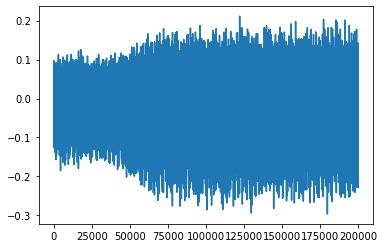

In [3]:
#So, while we prep for performing an FFT analysis, let's see what it looks like.
Sec = 5 #seconds of data collected
normalized_data = df[df.columns[1]]
normalized_data = normalized_data.to_numpy()
plt.plot(normalized_data[:200000])
plt.show

In [4]:
#the number of rows in the table
N=len(normalized_data)
print(N)

255750


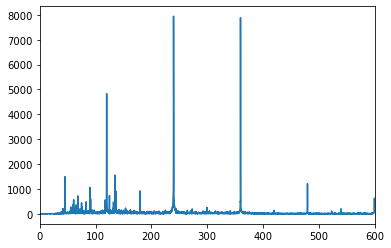

In [5]:
#What happens if we zoom in and ignore the rediculously high line frequency peak - or peaks.
Sample_Rate = samprate
N = len(normalized_data)
yf = rfft(normalized_data)
xf = rfftfreq(N,1/Sample_Rate)

plt.plot(xf,np.abs(yf))
plt.xlim([0,600])#change to select range, which should be no more than Sample_Rate/2 (Nyquist)
#plt.ylim([0,5000])
plt.show()

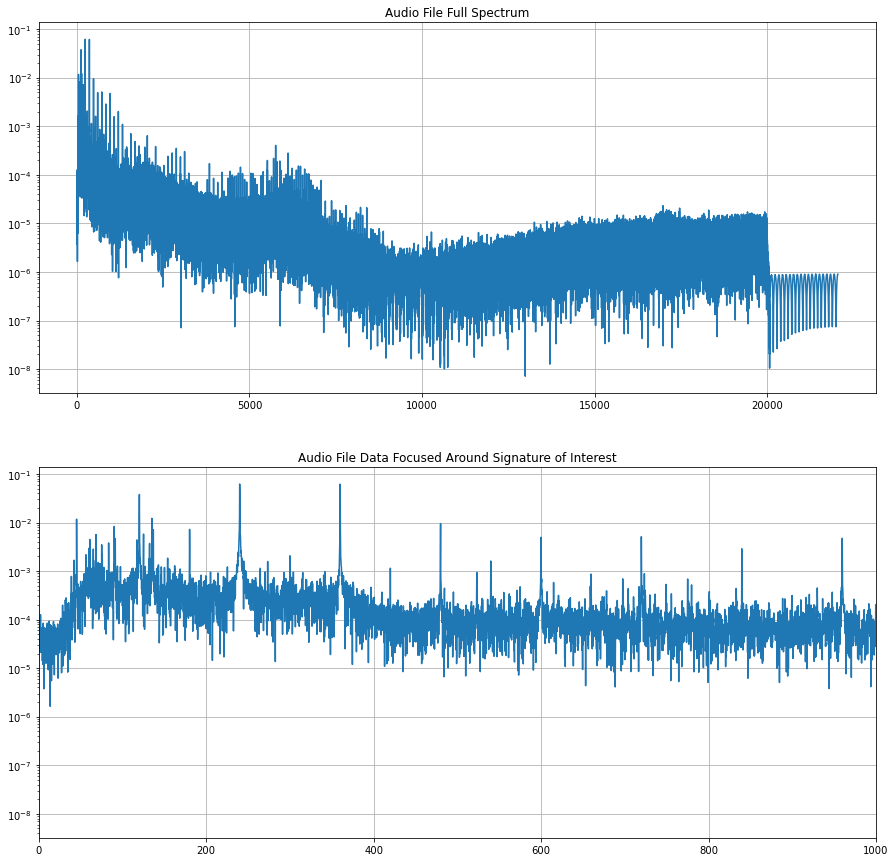

In [6]:
#OK, now lets look at the real logarithmic graph in dB.  These are not the values we expect, but it gets us in the right
#direction.

#The transformer is real.  It is a 115kV:13.8kV, 12,500 kVA oil filled power transformer that is exposed to low
#power factor and high harmonics at a manufacturing facility.

#Now we are off to a good start.  What else can we do with this data?  See below as we start working on resolution,
#windows, and a bunch of other things to get this signature to look like what we see on an analyzer.
T = 1/Sample_Rate #sampling frequency (sec)
y = normalized_data

yf = abs(fft(y)) #perform fft returning magnitude
xf = np.linspace(0.0,1.0/(2.0*T), N//2)#determine frequency bins

freqs = fftfreq(N,T)

ax2 = plt.figure(figsize=(15,15))


ax2 = plt.subplot(212)
yf2 = 2/N*np.abs(yf[0:N//2]);
ax2.semilogy(xf,yf2)
plt.grid()
ax2.set_title("Audio File Data Focused Around Signature of Interest")
ax2.set_xlim([0,1000])

ax3 = plt.subplot(211)
yf2 = 2/N*np.abs(yf[0:N//2]);
ax3.semilogy(xf,yf2)
plt.grid()
ax3.set_title("Audio File Full Spectrum")
plt.show()

### What we will do now is review a few filters.

The first one of interest would be the Hanning Window followed by the Flat Top Window and a Hamming Window.  There are your more common filters used for current signature analysis in most rotating machinery systems.

The purpose of the filters is to smooth the data.  For vibration analysis one of the most common is the Hanning Window.  However, there will tend to be less sharp peaks and it requires enough data collection time to be effective.  Following is the above data in a Hanning Window.

Note: The actual name is 'Hann' window.  Many refer to it as 'Hanning' because of the 'Hamming' window.

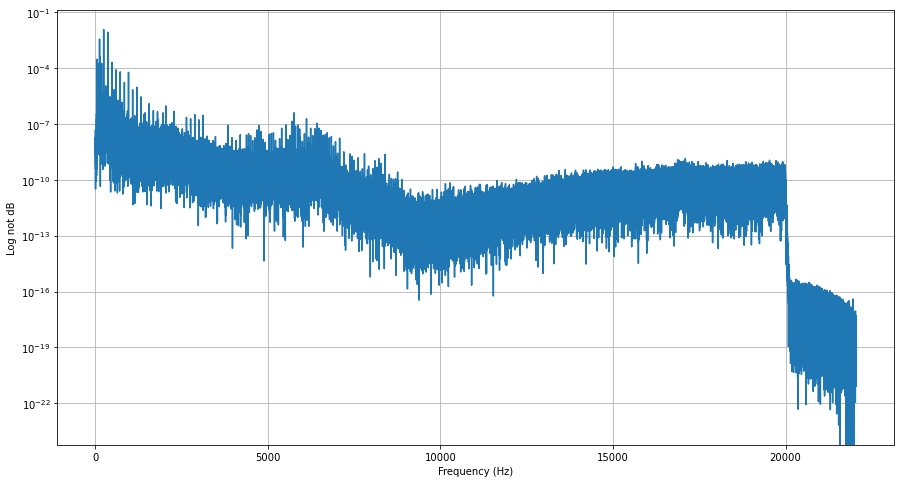

In [7]:
#this presents the complete nyquist range (half the sampling rate of 44,000 in this case)
freqs,psd = welch(normalized_data, fs=Sample_Rate,window='hanning',nperseg=N)
plt.figure(figsize=(15,8))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log not dB")
plt.grid()
plt.semilogy(freqs, psd)


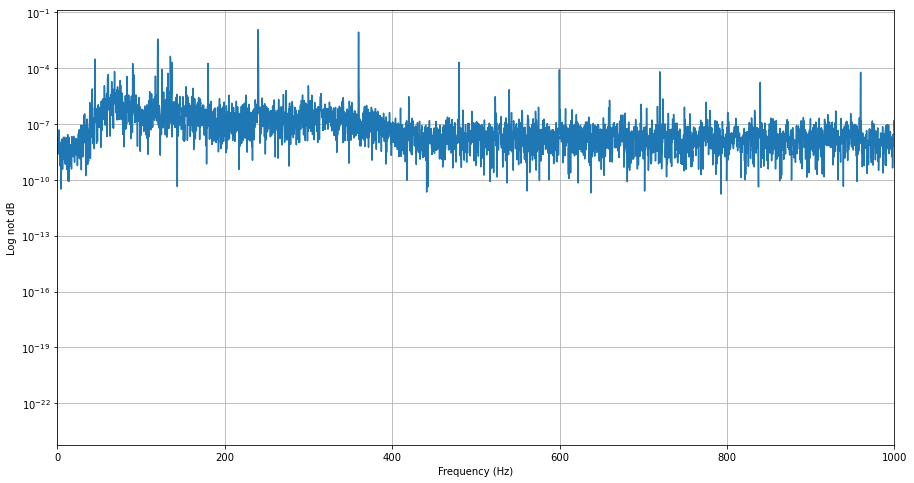

In [8]:
plt.figure(figsize=(15,8))
plt.xlim([0,1000]) #used to alter x axis in order to zoom.  This can be done in other libraries such as plotly, etc.
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log not dB")
plt.grid()
plt.semilogy(freqs,psd)

Now lets see what happens with a Flat Top Window

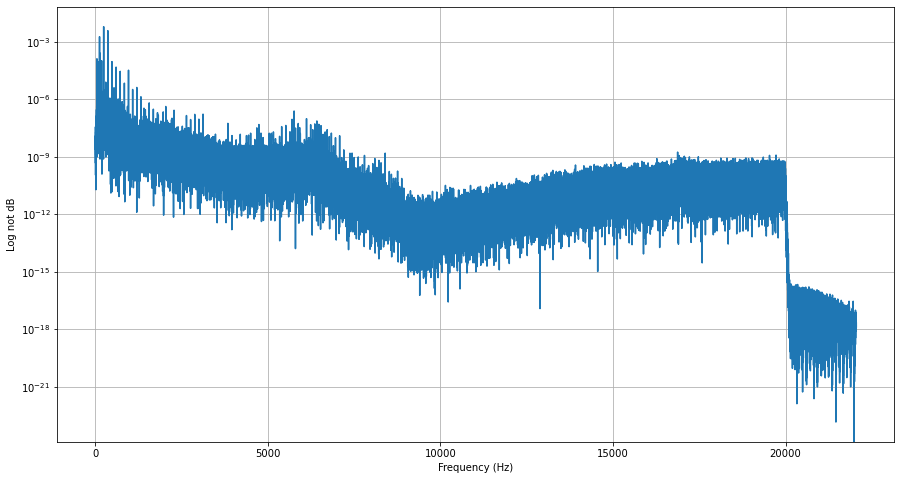

In [9]:
freqs,psd = welch(normalized_data, fs=Sample_Rate,window='flattop',nperseg=N)
plt.figure(figsize=(15,8))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log not dB")
plt.grid()
plt.semilogy(freqs, psd)

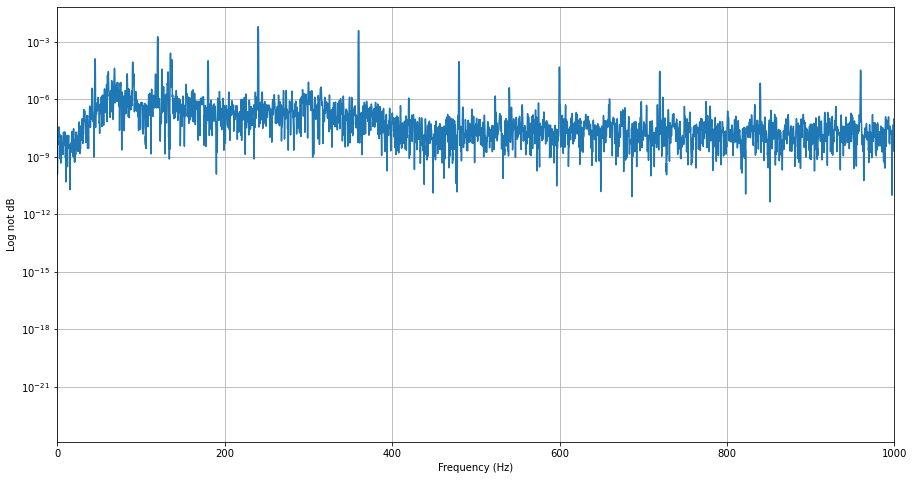

In [10]:
plt.figure(figsize=(15,8))
plt.xlim([0,1000])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log not dB")
plt.grid()
plt.semilogy(freqs,psd)

Or a Hamming Window

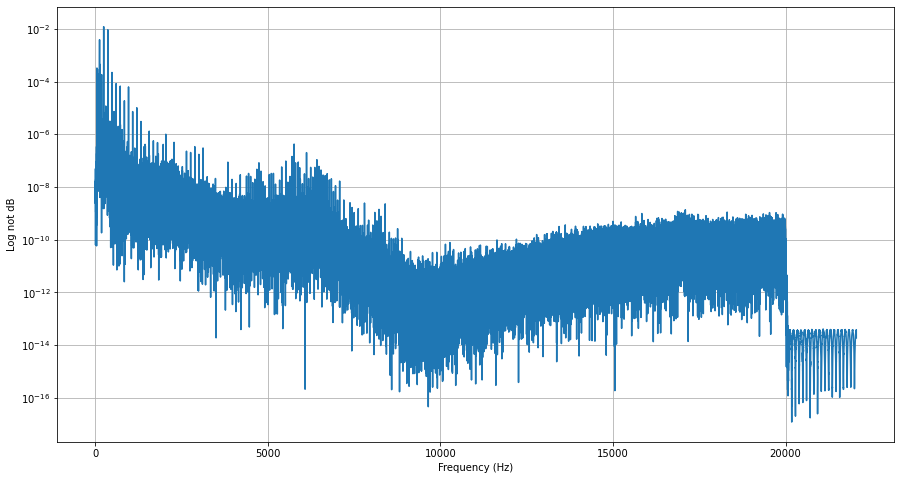

In [11]:
freqs,psd = welch(normalized_data, fs=Sample_Rate,window='hamming',nperseg=N)
plt.figure(figsize=(15,8))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log not dB")
plt.grid()
plt.semilogy(freqs, psd)

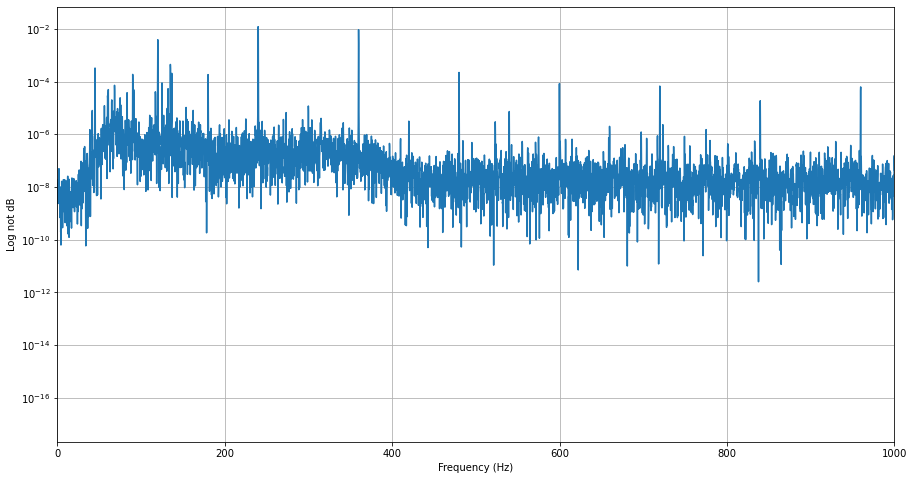

In [12]:
plt.figure(figsize=(15,8))
plt.xlim([0,1000])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Log not dB")
plt.grid()
plt.semilogy(freqs,psd)

### Convert the Y-Axis to dB in Noise

To this point in our exersize we have not dealt with averages nor changing the y-axis from logarithmic mean to actual -dB (decibels), which is what we use.  For current dB the conversion is 20*log10.  We will first convert everything we need to current dB (-dB) and then will review the data in a Flat Top window.  One of the challenges we have with the dataset above is that it is too short to perform any reasonable averages and have sharp peaks as we would have to change 'nperseg' to some other value.  For this exercise we will start with dB and then work on averages another time.  We will also compare a larger sampling to this sample as a comparison.

For our purposes, we will not go through the extra code to show the values as negative.  There's another reason for this.

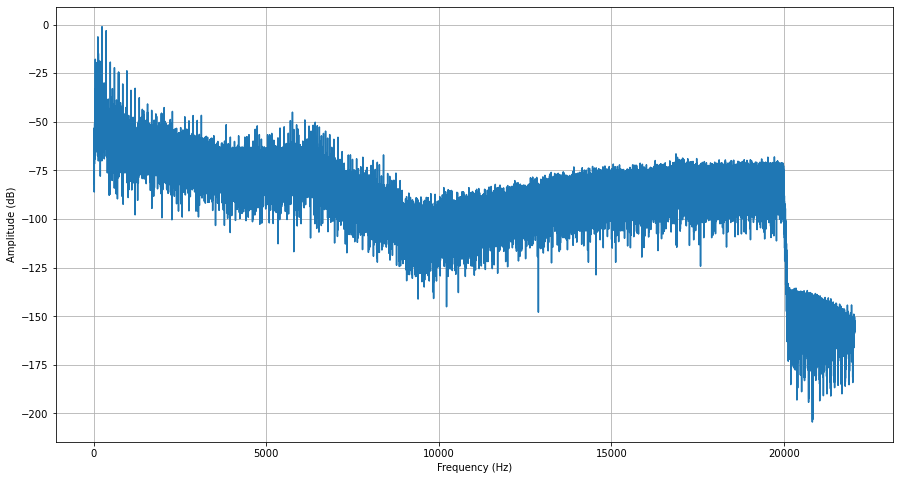

In [13]:
#This set of code will convert everything from before to dB as positive values.  Just to make it confusing,
#we still need to compare the peak of the line frequency to the peak of the value of interest.  In commercial
#systems the peak will normally be presented as '0' and all other values as '-dB' or 'dB down.'

#first we will define a function as dbfft
def dbfft(x, fs, win=None, ref=99574):#21474831.  Adjust reference until highest peak is 'zero'
    #Calculate spectrum in dB scale
    #Args:
        #x: input signal
        #fs: sampling frequency
        #win: vector containing window samples (same length as x)
        #ref: reference value used for dBFS scale.  32768 for int16 and 1 for float.
    #Returns:
        #freq: frequency vector
        #s_db: spectrum in dB scale
        
    N = len(normalized_data) #length of input sequence.  We will use the conditioned data.
    if win is None:
        win=np.ones(1,N)
    if len(normalized_data)!=len(win):
        raise ValueError('Signal and window must be of the same length')
    x = normalized_data*win
    
    #calculate the real FFT and frequency vector
    sp = rfft(x)
    freq = np.arange((N/2)+1)/(float(N)/fs)
       
    #scale the magnitude of FFT by window and factor of 2
    #as we are using half of FFT spectrum
    s_mag = np.abs(sp)*2/np.sum(win)
    
    #convert to dBFS
    s_dbfs = 20*np.log10(s_mag/ref)
    
    return freq, s_dbfs

#def main():
#load the file
N=N
win=flattop(N)
fs=Sample_Rate

win=flattop(N)
fs=Sample_Rate
freq1, s_dbfs=dbfft(normalized_data[0:N],fs,win)

#freq = freq1[:-1]
freq = freq1

#scale from dbfs to db
K=120
s_db=s_dbfs + K

    
plt.figure(figsize=(15,8))
plt.plot(freq, s_db)
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.show()


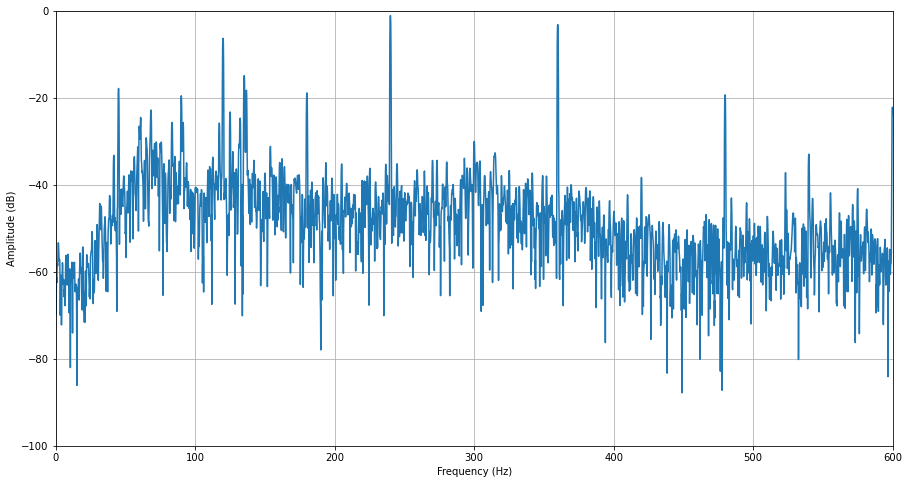

In [14]:
#now we will come in closer and crop the data so that we are looking at the line frequencies and multiples.
plt.figure(figsize=(15,8))
plt.plot(freq, s_db)
plt.xlim([0,600])
plt.ylim([-100,0])
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.show()

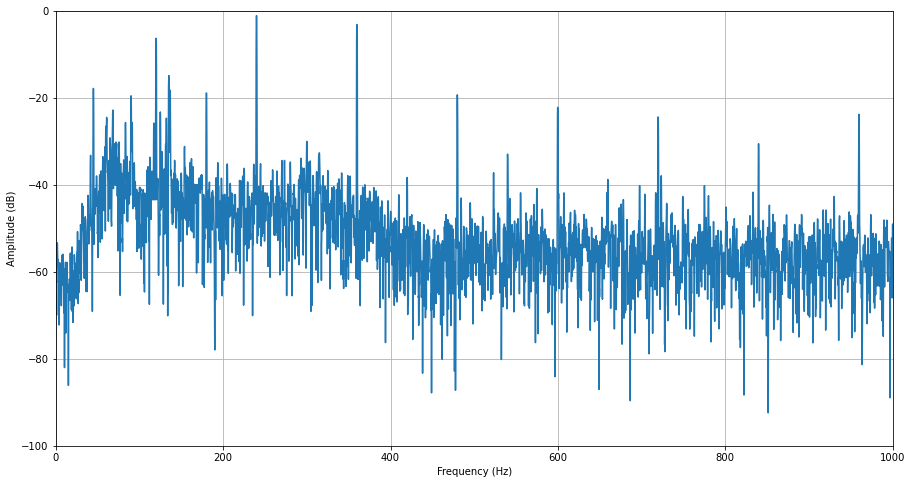

In [15]:
#in this one lets zoom out to see up to 1000 Hz.
plt.figure(figsize=(15,8))
plt.plot(freq, s_db)
plt.xlim([0,1000]) #alter to change x axis
plt.ylim([-100,0])
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.show()

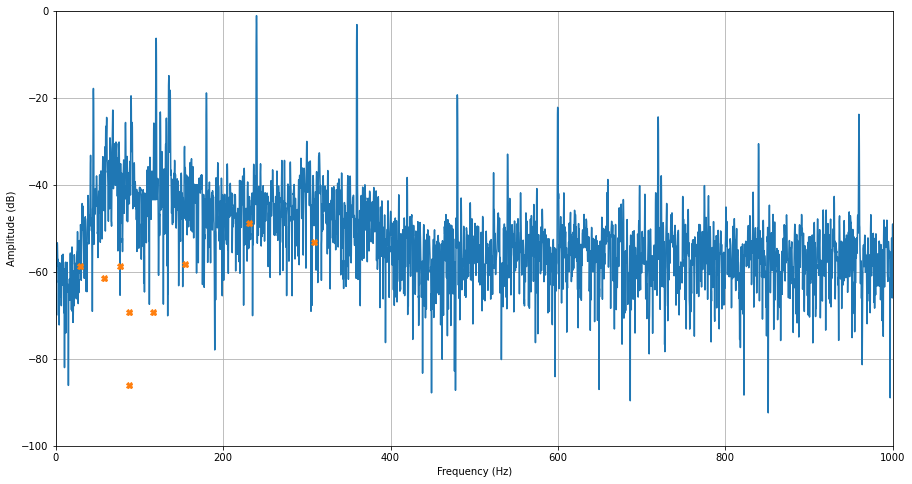

In [16]:
#A FEW FIXES WILL HAPPEN HERE B4 NEXT ARTICLE
#in this one lets zoom out to see up to 1000 Hz with peaks highlighted.
#Note that the peaks in this 'find_peaks' method does not land them directly on the peak in the spectra and produces
#an integer.  This is one of the challenges in Python.  There are ways around this that can be managed in Python, but
#are out of scope for this demonstration.  The peak values in -dB are correct, however.
peaks,properties = find_peaks(s_db, height=-20)
peaks = peaks//9
s_db = np.append(s_db, s_db[0])
plt.figure(figsize=(15,8))
s_db = s_db[:-1]
plt.plot(freq1, s_db)
plt.plot(peaks,s_db[peaks],"X")
plt.xlim([0,1000])
plt.ylim([-100,0])
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.show()


In [17]:
#A FEW FIXES WILL HAPPEN HERE B4 NEXT ARTICLE
#Actual peak values for the spectra at ~values.  Note LF is not exactly zero.  In this case, in the above, we have a number of values
# greater than the -20dB down that we selected.
x = []
y = []

for i in peaks:
    x.append(i)
for j in properties['peak_heights']:
    y.append(j)
PeakData = pd.DataFrame({'~Peak Frequency':x, 'Peak dB Difference':y})
PeakData.head(15)

,~Peak Frequency,Peak dB Difference
0,29,-17.827783
1,58,-19.523070
2,77,-6.307582
3,87,-14.881611
4,88,-18.245334
5,116,-18.855686
6,154,-1.086895
7,231,-3.146127
8,309,-19.297145


In [19]:
#A FEW FIXES WILL HAPPEN HERE B4 NEXT ARTICLE
#Actual peak values for the spectra at ~values.  Note LF is not exactly zero.  In this case, in the above, we have 29 values
# greater than the -20dB down that we selected.
x = []
y = []

for i in freq1:
    x.append(i)
for j in s_db:
    y.append(j)
PeakData = pd.DataFrame({'frequency':x, 'decibels':y})
PeakData = PeakData[PeakData.frequency<1500]
PeakData.head(14)
#PeakData.to_csv("soundfreq.csv")

,frequency,decibels
0,0.000000,-65.048853
1,0.172434,-69.885870
2,0.344868,-69.568986
3,0.517302,-61.190205
4,0.689736,-61.999543
...,...,...
9,1.551906,-57.312350
10,1.724340,-54.294997
11,1.896774,-53.327106
12,2.069208,-53.821373


For more information follow the Motor Diagnostics and Motor Health Newsletter by signing up on any of the MotorDoc LLC official websites: www.motordoc.com www.empathcms.com or www.motordocai.io

Copyright 2022, MotorDoc LLC, 1141 S Main St., Lombard, IL 60148